# Predicting the Price of New York City Airbnbs
DSCI 310: Group 9

By Oliver Gullery, Prithvi Sureka, Riddhi Battu, Rashi Selarka

In [90]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import folium

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import requests
from branca.colormap import linear
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Summary

# Introduction

Airbnb has been one of the most popular short-term stays and rental online services since 2008, expanding to over a thousand cities in less than a year (Geron, 2009). Owing to its exponential growth however, many metropolises such as Paris, London, Berlin, and New York City started introducing special rules and laws for creating a listing on Airbnb due to its impact on housing shortages and rental markets (Tun, 2023). In September 2023, New York enforced a measure called Local Law 18 (Oladipo, 2023), that was essentially a de facto ban on short-term rentals that would force the amount of listings to decrease 85% within the month (Chan, 2023), and decrease over 90% as of 2024 from what they were in 2022 (Bellafante, 2024). Consequently, this led average prices to surge, and led us to want to investigate factors of New York Airbnbs and how they impact listing prices.

We were able to obtain a workable and descriptive dataset about New York Airbnbs from [insideairbnb.com](http://insideairbnb.com/new-york-city/) (New York City, 2024) that gave insight into every listing from 2011 to 2023 and their reviews. The fields present in our dataset are:

* ID: Unique identifier for listing
* Name: Name of listing, followed by rating and type (e.g. 1 bed 1 bath)
* Host ID: Unique identifier for host
* Host Name: Name of host
* Neighbourhood: Neighbourhood where listing is located
* Neighbourhood Group: Borough where listing is located
* Latitude: Latitudinal coordinate of listing location
* Longitude: Longitudinal coordinate of listing location
* Room Type: Listing space type (Private room, Entire home / Apt., etc.)
* Price: Price per Night in USD
* Minimum Nights: Minimum nights required to stay at the rental
* Number of Reviews: Total number of reviews on the listing
* Last Review: Date of latest review on the rental
* Reviews Per Month: Avg. monthly number of reviews on the listing
* Calculated Host Listings Count: Number of listings the corresponding host has
* Availability 365: Number of days in a year listing is available for booking

Here we intend to use a machine learning algorithm to predict Airbnb prices per night using most of the above factors. There have been multiple studies looking into how the Airbnb ban impacts NYC rental (Fields, 2023) and hotel prices (Kelly, 2023), but not as much into the Airbnb prices themselves. Since our investigation will be solely based on data up until 2023, it can be used glean exactly how these restrictions impacted Airbnb prices in NYC when compared with information from 2024 onwards (i.e. was it because the number of listings per host went down? Or was it because the minimum number of nights required to stay went up? and more questions like that).

# Methods

## 1. Data

### 1.1 Loading + Exporting Data to csv

In [91]:
# loading the data
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2023-12-04/visualisations/listings.csv"

data = pd.read_csv(url_listings)
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Rental unit in New York · ★4.68 · Studio · 1 b...,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240,30,49,2022-06-21,0.29,3,339,0,NaN
1,5121,Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,66,30,50,2019-12-02,0.28,2,88,0,NaN
2,6848,Rental unit in Brooklyn · ★4.58 · 2 bedrooms ·...,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,191,2023-08-14,1.08,1,142,4,NaN


In [92]:
# saving the data file to /data/raw
data.to_csv("../data/raw/airbnb_data_2023")

## 2. Exploratory Data Analysis

### 2.1 Preliminary EDA

In [93]:
# Data shape & datatypes
print(f'Data Shape: {data.shape}\n')
print(f'Data datatypes: \n{data.dtypes}')

Data Shape: (39627, 18)

Data datatypes: 
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object


### 2.2 Summary Statistics

In [94]:
data.info()

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39627 entries, 0 to 39626
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39627 non-null  int64  
 1   name                            39627 non-null  object 
 2   host_id                         39627 non-null  int64  
 3   host_name                       39612 non-null  object 
 4   neighbourhood_group             39627 non-null  object 
 5   neighbourhood                   39627 non-null  object 
 6   latitude                        39627 non-null  float64
 7   longitude                       39627 non-null  float64
 8   room_type                       39627 non-null  object 
 9   price                           39627 non-null  int64  
 10  minimum_nights                  39627 non-null  int64  
 11  number_of_reviews               39627 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.962700e+04,3.962700e+04,39627.000000,39627.000000,39627.000000,39627.000000,39627.000000,28147.000000,39627.000000,39627.000000,39627.000000
mean,3.083450e+17,1.602573e+08,40.729360,-73.946072,208.816464,30.051127,25.251520,1.021708,41.852197,153.721276,6.264088
std,4.050888e+17,1.717839e+08,0.056425,0.054788,482.380712,29.290027,57.718207,1.716199,124.056880,147.391076,16.602446
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,8.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.023932e+07,1.692691e+07,40.688980,-73.982785,75.000000,30.000000,0.000000,0.110000,1.000000,0.000000,0.000000
50%,4.650264e+07,8.066903e+07,40.726520,-73.954090,127.000000,30.000000,4.000000,0.390000,1.000000,122.000000,0.000000
75%,7.564324e+17,2.857275e+08,40.762667,-73.926560,214.000000,30.000000,22.000000,1.415000,6.000000,319.000000,4.000000
max,1.037983e+18,5.491316e+08,40.911380,-73.713650,30000.000000,1250.000000,1857.000000,71.160000,691.000000,365.000000,983.000000


### 2.3 Identifying Null Values & Duplicates

In [95]:
print(f'Null Values: {data.isna().sum()}\n')
print(f'Duplicated Values: {data.duplicated().sum()}')

Null Values: id                                    0
name                                  0
host_id                               0
host_name                            15
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11480
reviews_per_month                 11480
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           35268
dtype: int64

Duplicated Values: 0


In [96]:
# minor statistics about License
print(f'License Summary Statistics: \n{data["license"].describe()}')

License Summary Statistics: 
count       4359
unique       700
top       Exempt
freq        3408
Name: license, dtype: object


### 2.4 Correlations between Numerical Data (Top 10)

In [97]:
# creating correlation matrix from numeric data (exlucding host_id and id)
corr_matrix = data.select_dtypes(include=["int64", "float64"]).drop(['host_id','id'], axis=1).corr()

def rank_correlations(corr_matrix):
    # flattening matrix
    flattened_matrix = corr_matrix.stack().reset_index()

    #renaming columns
    flattened_matrix.columns = ['Variable_1', 'Variable_2', 'Correlation']

    # removing duplicate variable names
    flattened_matrix = flattened_matrix.loc[flattened_matrix['Variable_1'] != flattened_matrix['Variable_2']]

    corr_column = flattened_matrix['Correlation']

    flattened_matrix = flattened_matrix.iloc[abs(corr_column).argsort()[::-1]]

    flattened_matrix = flattened_matrix.loc[flattened_matrix['Correlation'].duplicated()]


    print(f'Top 10 Variable Correlations: \n{flattened_matrix.head(10)}')

rank_correlations(corr_matrix)

Top 10 Variable Correlations: 
                        Variable_1                      Variable_2  \
77           number_of_reviews_ltm               reviews_per_month   
49               reviews_per_month               number_of_reviews   
76           number_of_reviews_ltm               number_of_reviews   
61  calculated_host_listings_count                availability_365   
52               reviews_per_month                availability_365   
42               number_of_reviews  calculated_host_listings_count   
19                           price                       longitude   
78           number_of_reviews_ltm  calculated_host_listings_count   
32                  minimum_nights               reviews_per_month   
46               reviews_per_month                       longitude   

    Correlation  
77     0.859984  
49     0.646637  
76     0.645866  
61     0.137655  
52     0.130711  
42    -0.129957  
19    -0.117793  
78    -0.109144  
32    -0.106898  
46     0.088384  


**Fig. 1 Correlation Heat Map of Numerical Predictors**

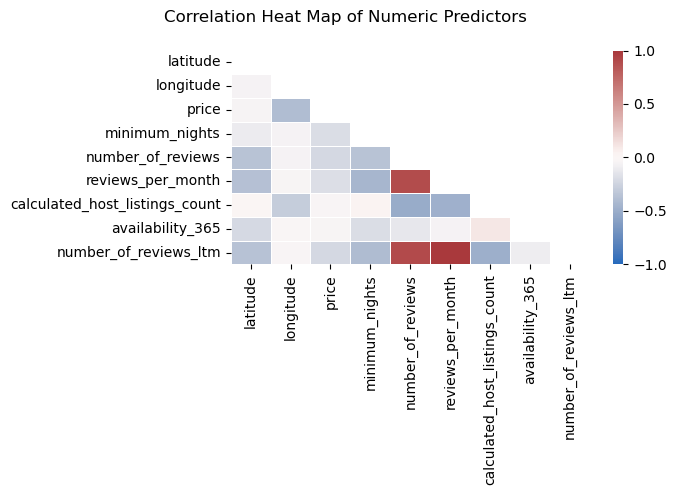

In [98]:
# Fig. 1

train_corr = corr_matrix.corr(method = 'pearson')
mask = np.zeros_like(train_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True ## Uncomment to clear half the map

fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(train_corr, mask=mask, vmin=-1, vmax=1, center=0, linewidths=.5, cmap="vlag")
fig.suptitle('Correlation Heat Map of Numeric Predictors', fontsize=12)
fig.tight_layout()

### 2.5 Takwaways From Preliminary EDA

- Our shape function tells us we have 39627 rows and 18 features which includes our target variable `price`. 

- Looking at the columns from our info() function we can identify that name is a text type data which could provide some valuable insights. We can also infer that any id information (`id` and `host_id`) and variables such as `host_name` will not provide any key information, thus, we can drop them for our data analysis.

- The describe() function provided key summary statistics for our numeric columns which included the following metrics: count, mean, standard deviation, minimum, and maximum. This helps us better understand the spread of our data. Our info() function gave us further information about the datatypes, columns, and amount of data we have.

- Our isna() function informed us of the null values which are included in the dataset. The columns `host_name` has *15* null values but this is irrelevant as we will drop this column. Our `reviews_per_month` column and `last_review` column have *11480* null values each. This suggests that when a airbnb listing doesn't have a review, it was listed as a null value in the data. To fix this we could impute 0 into the nulls for `reviews_per_month`. For `last_review`, we decided it would be appropriate to drop the column as some of the information it provides is stored in reviews per month.

- `license` has a significant number of null values with 35268. It might provide some interesting insights into price as a license is proof that the airbnb owners comply with the regulatory standards, but since the nature of these missing values is unknown, we cannot be sure if the null values means the listing has no license. Due to this imbalance in the data, we decided it best to drop this column. However, it could be worth exploring the relationship between license and other variables in future analyses.

### 2.6 Next Steps for Feature Engineering

In order to prepare our data for further analysis we must perform some preliminary feature engineering which will involve:
- Convert `id` and `host_id` into object datatypes to prepare them to be dropped.
- Impute zeros into the `reviews_per_month` null values.
- Segregate fields into target column, categorical, numerical, text data, and drop data.
- Split the data into training and test sets.

## 3. Preliminary Feature Engineering

### 3.1 Convert `id` and `host_id` into object datatypes to prepare them to be dropped.

In [99]:
data['id'] = str(data['id'])
data['host_id'] = str(data['host_id'])

### 3.2 Impute zeros into the `reviews_per_month` column for null values.

In [100]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

### 3.3 Segregate fields into target column, categorical, numerical, text, and drop data.

In [101]:
# target column
target_data = ['price']

# numeric data
numerical_data = data.select_dtypes(include=["int64", "float64"]).drop(target_data, axis=1)
numerical_data = numerical_data.columns

# text data
text_data = ["name"]

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = data.select_dtypes(include=["object"])
categorical_data = categorical_data.columns
columns_to_exclude = text_data + drop_data
categorical_data = [col for col in categorical_data if col not in columns_to_exclude]


print(f"Target Column: {target_data}\n")
print(f"Numerical Columns: {numerical_data}\n")
print(f"Categorical Columns: {categorical_data}\n")
print(f"Text Data: {text_data}\n")
print(f"Drop Columns: {drop_data}\n")

Target Column: ['price']

Numerical Columns: Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

Categorical Columns: ['neighbourhood_group', 'neighbourhood', 'room_type']

Text Data: ['name']

Drop Columns: ['host_name', 'host_id', 'id', 'license', 'last_review']



### 3.4 Split the data into training and test sets.

In [102]:
train_df, test_df = train_test_split(data, test_size=0.2, shuffle=True)

X_train = train_df.drop(['price'], axis=1)
y_train = train_df['price']
X_test = test_df.drop(['price'], axis=1)
y_test = test_df['price']

print(f'Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}\n')

print(f'Input Variables (includes drop data): {X_train.columns}\n')
print(f'Target Variable: {y_train.name}\n')

Train Shape: (31701, 18)
Test Shape: (7926, 18)

Input Variables (includes drop data): Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

Target Variable: price



## 4. Analysis

### 4.1 Relationships between Predictors Visualized

**Fig. 2 Map with Distribution of Listings by Location and Price**

(-0.5, 1325.5, 1290.5, -0.5)

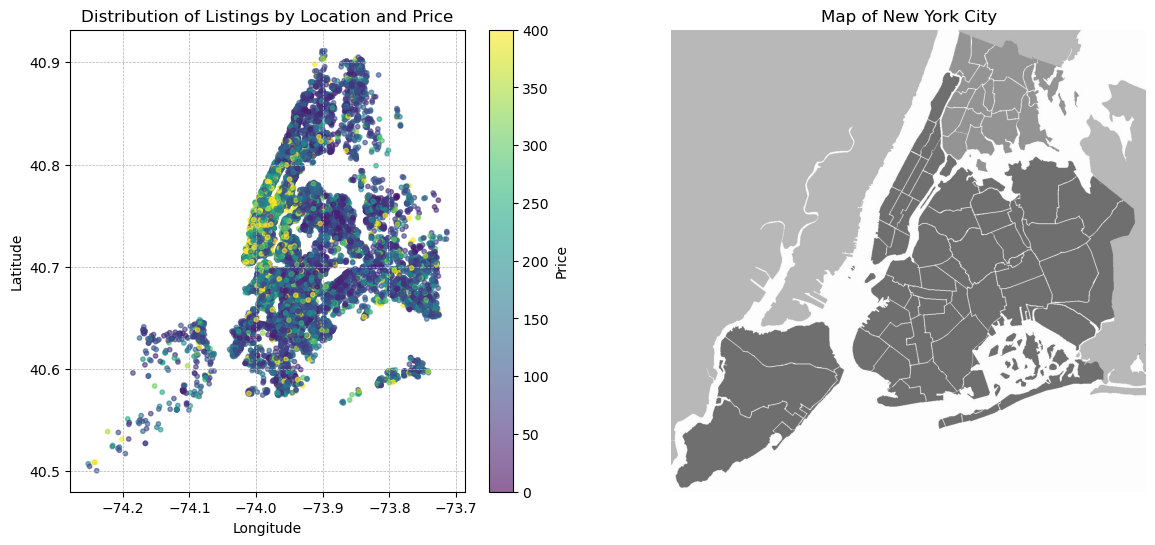

In [103]:
# Fig. 2
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 6))

# Setting color limits to more typical range, e.g., 0 to 400
# Adjust these values based on your specific dataset and its distribution
vmin, vmax = 0, 400

ax[0].scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], #cmap='viridis',
            s=10, alpha=0.6, vmin=vmin, vmax=vmax)
fig.colorbar(plt.scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], #cmap='viridis',
            s=10, alpha=0.6, vmin=vmin, vmax=vmax), label='Price', ax=ax[0])
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].set_title('Distribution of Listings by Location and Price')
ax[0].set(xlabel='Longitude', ylabel='Latitude')

img = mpimg.imread('images/New_York_City_Map.jpg')

ax[1].imshow(img)
ax[1].set_title('Map of New York City')
ax[1].axis("off")

**Fig. 3 Price vs Number of Reviews Coloured by Room Type Scatterplot**

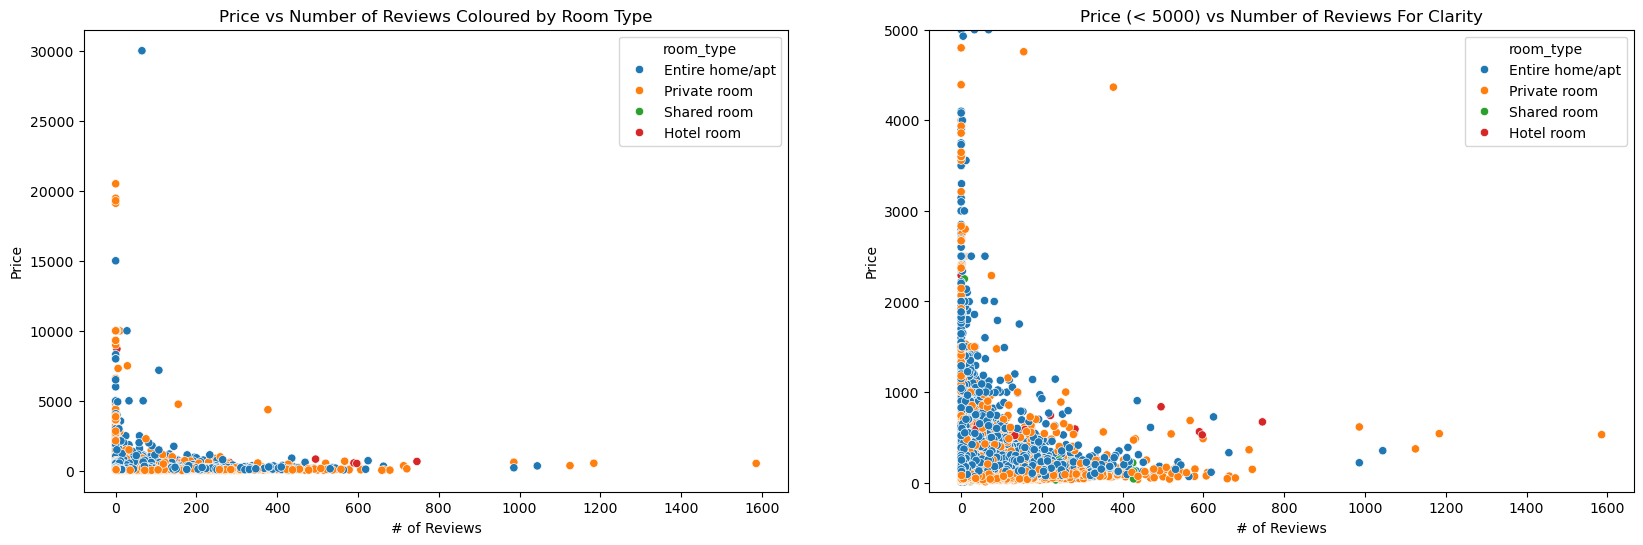

In [104]:
# Fig. 3

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Number of Reviews Coloured by Room Type")
ax[0].set(xlabel="# of Reviews", ylabel="Price")

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Number of Reviews For Clarity")
ax[1].set(xlabel="# of Reviews", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

**Fig. 4 Price vs Reviews Per Month Coloured by Room Type Scatterplot**

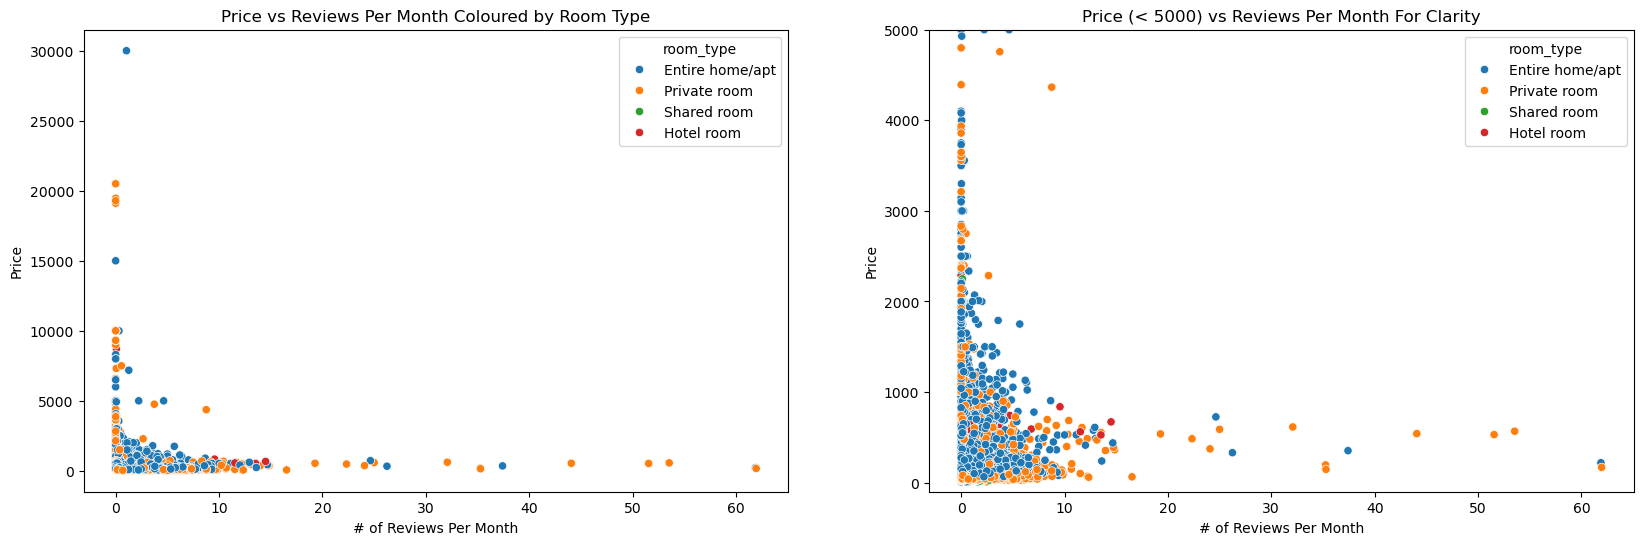

In [105]:
# Fig. 4

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Reviews Per Month Coloured by Room Type")
ax[0].set(xlabel="# of Reviews Per Month", ylabel="Price")

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Reviews Per Month For Clarity")
ax[1].set(xlabel="# of Reviews Per Month", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

**Fig. 5 Log Price and Price by Neighbourhood Group Boxplot**

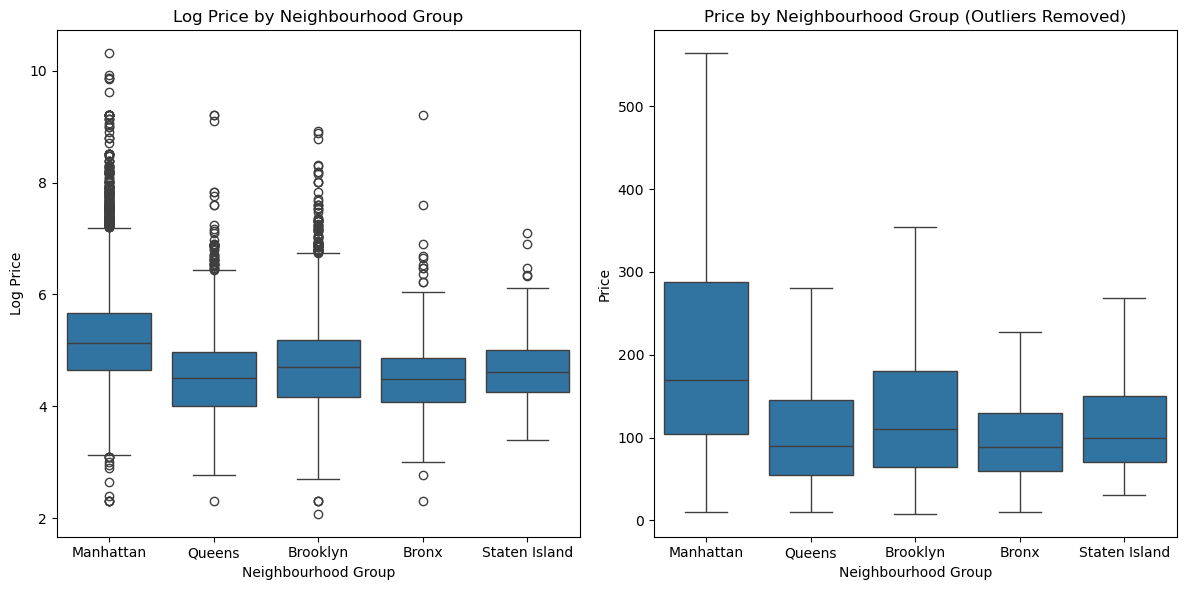

In [106]:
# Fig. 5

log_price = np.log(train_df['price'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# fig 1
sns.boxplot(x='neighbourhood_group', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Log Price by Neighbourhood Group')
axes[0].set_xlabel('Neighbourhood Group')
axes[0].set_ylabel('Log Price')
# fig 2
sns.boxplot(x='neighbourhood_group', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Price by Neighbourhood Group (Outliers Removed)')
axes[1].set_xlabel('Neighbourhood Group')
axes[1].set_ylabel('Price')

plt.tight_layout() 
plt.show()

**Fig. 6 Log Price and Price by Room Type Boxplot**

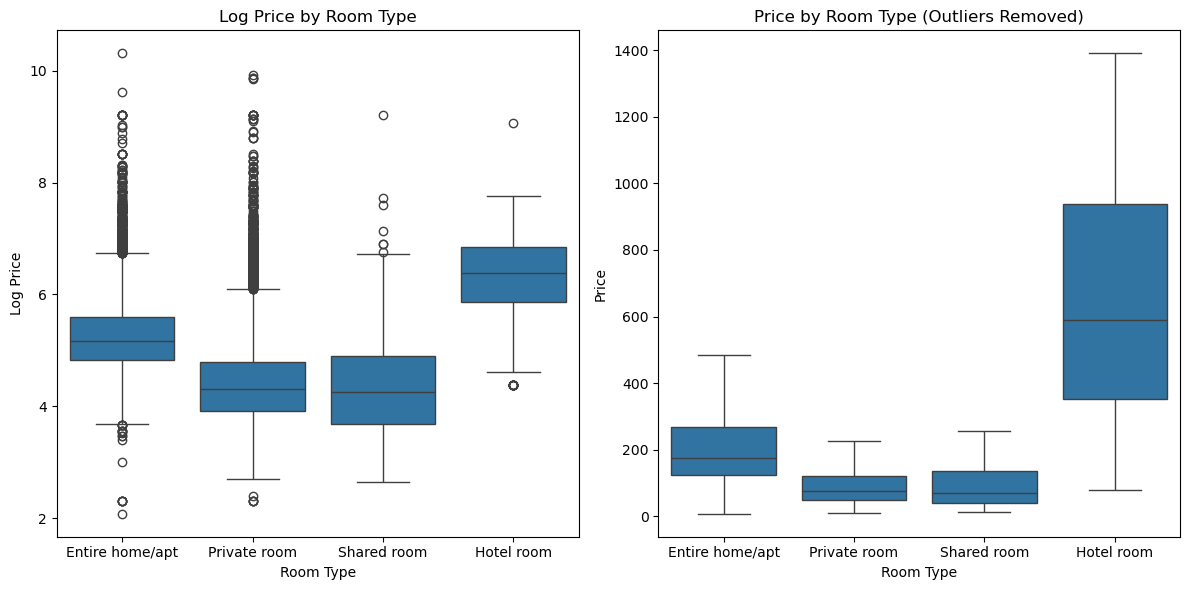

In [116]:
# Fig. 6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(x='room_type', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Log Price by Room Type')
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Log Price')

sns.boxplot(x='room_type', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Price by Room Type (Outliers Removed)')
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Price')


plt.tight_layout()  
plt.show()

### 4.2 Preprocessing & Transformations

**4.2.1 Defining Transformations & Preparing Data**

In [108]:
# Numerical Transformer
numerical_transformer = StandardScaler()

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Text Data Transformer
text_transformer = CountVectorizer()

In [109]:
# target column
target_data = ['price']

# numeric data
numerical_data = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm']

# text data
text_data = "name"

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = ['neighbourhood_group', 'neighbourhood', 'room_type']
X_train[text_data].head(3)

21811        Loft in New York · ★4.77 · 1 bedroom · 1 bath
39515    Home in Queens · ★New · 1 bedroom · 2 beds · 1...
13801    Home in Brooklyn · ★4.75 · 1 bedroom · 1 bed ·...
Name: name, dtype: object

**4.2.2 Making Our Preprocessor**

In [110]:
preprocessor = make_column_transformer(
    (numerical_transformer, numerical_data),
    (categorical_transformer, categorical_data),
    (text_transformer, text_data),
    remainder='drop'
)

**4.2.3 Implementing a Baseline Model**

We can implement a Dummy Regressor model as a baseline to assess our model with. 

In [111]:
dummy_model = DummyRegressor()

dummy_pipe = make_pipeline(preprocessor, dummy_model)
dummy_pipe.fit(X_train, y_train)
# dummy_predictions = dummy_pipe.predict(X_test)
f'Test Score is: {dummy_pipe.score(X_test, y_test)}'



'Test Score is: -1.57294085056936e-05'

## 5. Model & Results

### 5.1 Building a model using Ridge Regression

In [112]:
def eval_model(model, X_train, y_train, return_train_score=True):
    """
    Evaluates the model using cross validation scores 
    """
    scores = cross_validate(model, X_train, y_train, return_train_score=return_train_score)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [113]:
ridge_pipe = make_pipeline(preprocessor, Ridge())

ridge_model = ridge_pipe.fit(X_train, y_train)


eval_model(ridge_model, X_train, y_train)

C:\Users\rashi\AppData\Local\Temp\ipykernel_9376\3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.504 (+/- 0.036)
score_time     0.076 (+/- 0.004)
test_score     0.139 (+/- 0.046)
train_score    0.163 (+/- 0.018)
dtype: object

In [114]:
xg = xgb.XGBRegressor()

xg_pipe = make_pipeline(preprocessor, xg)

xg_model = xg_pipe.fit(X_train, y_train)

eval_model(xg_model, X_train, y_train)

C:\Users\rashi\AppData\Local\Temp\ipykernel_9376\3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.487 (+/- 0.004)
score_time     0.110 (+/- 0.004)
test_score     0.256 (+/- 0.119)
train_score    0.855 (+/- 0.032)
dtype: object

**Fig. 7 Top Feature Importances in the XGBoost Model**

In [117]:
# Fig. 7

top_n = 20

# Getting the indices of the top N features
sorted_idx = np.argsort(feature_importances)[-top_n:]

# Creating a simplified DataFrame for the top N features
# Note: Adjust feature_names construction if you have specific names you want to use
feature_names = [f'Feature {i}' for i in range(len(feature_importances))]
top_feature_names = [feature_names[i] for i in sorted_idx]
top_feature_importances = feature_importances[sorted_idx]

# Plotting
plt.figure(figsize=(3, 3))
plt.barh(range(top_n), top_feature_importances, align='center')
plt.yticks(range(top_n), top_feature_names)
plt.title("Top N Feature Importances in the XGBoost Model")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

NameError: name 'feature_importances' is not defined

### 5.2 Hypereparamter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid
param_dist = {
    'xgbregressor__max_depth': randint(3, 10),
    'xgbregressor__min_child_weight': randint(1, 6),
    'xgbregressor__gamma': uniform(0, 0.5),
    'xgbregressor__subsample': uniform(0.5, 0.5),
    'xgbregressor__colsample_bytree': uniform(0.5, 0.5),
    'xgbregressor__lambda': uniform(1, 0),
    'xgbregressor__alpha': uniform(1, 0)
}

# Perform randomized search
search = RandomizedSearchCV(xg_pipe, param_distributions=param_dist, n_iter=100, scoring='r2', cv=5, verbose=1, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

# Best parameters and scores
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

# Evaluate the model with the best parameters
eval_model(search.best_estimator_, X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'xgbregressor__alpha': 1.0, 'xgbregressor__colsample_bytree': 0.5126753717077288, 'xgbregressor__gamma': 0.48132420733896253, 'xgbregressor__lambda': 1.0, 'xgbregressor__max_depth': 9, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.8442499503826832}
Best score: 0.28537870834132145


/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_2186/3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.578 (+/- 0.064)
score_time     0.059 (+/- 0.001)
test_score     0.285 (+/- 0.142)
train_score    0.937 (+/- 0.010)
dtype: object

## 6. Discussion

## 7. References

Bellafante, G. (2024, February 9). Can a new law force airbnb hosts to become landlords? *The New York Times.* Retrieved from https://www.nytimes.com/2024/02/09/nyregion/nyc-airbnb-rentals.html#:~:text=In%20May%202022%2C%20there%20were,and%20Newark%20exceeded%2053%20percent.

Chan, W. (2023, October 23). ‘We’re in a housing desert’: a month in, is new york’s airbnb crackdown working? *The Guardian.* Retrieved from https://www.theguardian.com/us-news/2023/oct/23/new-york-airbnb-crackdown-rules-housing.

Fields, S. (2023, August 24). *Can an airbnb crackdown really make New York more affordable?.* Marketplace. https://www.marketplace.org/2023/08/24/new-york-city-airbnb-crackdown-affordable-housing/

Geron, T. (2009, June 10). From crash pad to pizza profitable, start-up eyes budget travel market. *The Wall Street Journal.* Retrieved from https://www.wsj.com/articles/BL-VCDB-2042.

Kelly, G. (2023, December 21). *New York City’s airbnb ban is driving up hotel prices.* The Daily Upside. https://www.thedailyupside.com/industries/consumer/new-york-citys-airbnb-ban-is-driving-up-hotel-prices/ 

Oladipo, G. (2023, September 6). New york city’s crackdown on airbnb and short-term rentals goes into effect. *The Guardian.* Retrieved from https://www.theguardian.com/us-news/2023/sep/06/airbnb-new-rental-regulation-nyc-housing.

*New York City.* Inside Airbnb: Home. (2024, February 6). http://insideairbnb.com/new-york-city

Tun, Z. T. (2023, September 5). *Top cities where Airbnb is legal or illegal.* Investopedia. https://www.investopedia.com/articles/investing/083115/top-cities-where-airbnb-legal-or-illegal.asp